### Facebook research has recently brough out a new library with a pre-trained sentence encoder. https://github.com/facebookresearch/InferSent It is built on pytorch. The top section of this notebook is from their repo, below some tests are run to see if it is at all helpful to find similar sentences to help the chatbot project. Also tested it on some sentenches from an NLP competition. 

In [1]:
import nltk

In [2]:
# import stuff
%load_ext autoreload
%autoreload 2
%matplotlib inline

from random import randint
import matplotlib

import numpy as np
import torch

GLOVE_PATH = '../dataset/GloVe/glove.840B.300d.txt'

## Load model

In [3]:
# make sure models.py is in the working directory
model = torch.load('infersent.allnli.pickle')

/home/felix/.pyenv/versions/miniconda2-latest/lib/python2.7/site-packages/torch/serialization.py:284: SourceChangeWarning: source code of class 'models.BLSTMEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [4]:
# torch.load(..pickle) will use GPU/Cuda by default. If you are on CPU:
# model = torch.load('infersent.allnli.pickle', map_location=lambda storage, loc: storage)
# model.use_cuda = False

In [5]:
model.set_glove_path(GLOVE_PATH)

In [6]:
model.build_vocab_k_words(K=100000)

Vocab size : 100000


## Load sentences

In [7]:
# Load some sentences
sentences = []
with open('../dataset/MultiNLI/s2.dev.matched') as f:
    for line in f:
        sentences.append(line.strip())
print(len(sentences))

9815


In [8]:
sentences[:5]

['Everyone really likes the newest benefits',
 'The Government Executive articles housed on the website are not able to be searched .',
 'I like him for the most part , but would still enjoy seeing someone beat him .',
 'My favorite restaurants are always at least a hundred miles away from my house .',
 'I know exactly .']

## Encode sentences

In [9]:
# gpu mode : ~1000 sentences/s
# cpu mode : ~55 sentences/s

In [10]:
embeddings = model.encode(sentences, bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))

Nb words kept : 128201/130068 (98.56 %)
Speed : 1148.73 sentences/s (gpu mode, bsize=128)
nb sentences encoded : 9815


## Visualization

In [11]:
np.linalg.norm(model.encode(['the cat eats.']))

3.5349097

In [12]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [13]:
cosine(model.encode(['the cat eats.'])[0], model.encode(['the cat drinks.'])[0])

0.81652391

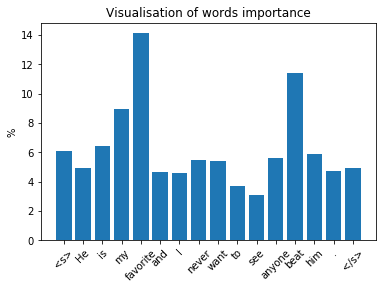

In [14]:
idx = randint(0, len(sentences))
_, _ = model.visualize(sentences[idx])

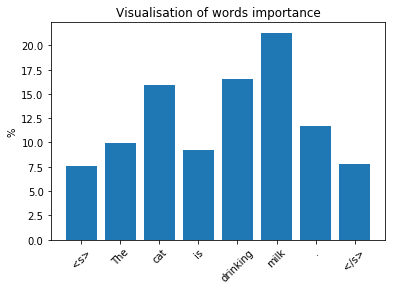

In [15]:
my_sent = 'The cat is drinking milk.'
_, _ = model.visualize(my_sent)

In [35]:
for method in dir(model):
    print method, "    ",

__call__      __class__      __delattr__      __dict__      __dir__      __doc__      __format__      __getattr__      __getattribute__      __hash__      __init__      __module__      __new__      __reduce__      __reduce_ex__      __repr__      __setattr__      __sizeof__      __str__      __subclasshook__      __weakref__      _apply      _backend      _backward_hooks      _buffers      _forward_hooks      _modules      _parameters      add_module      apply      bsize      build_vocab      build_vocab_k_words      children      cpu      cuda      double      dpout_model      dump_patches      enc_lstm      enc_lstm_dim      encode      eval      float      forward      get_batch      get_glove      get_glove_k      get_word_dict      glove_path      half      init_lstm      load_state_dict      modules      named_children      named_modules      named_parameters      parameters      pool_type      register_backward_hook      register_buffer      register_forward_hook      register_

In [19]:
cosine(model.encode(['the cat eats.'])[0], model.encode(['the cat drinks.'])[0])

0.81652391

In [21]:
cosine(model.encode(['I love Microsoft.'])[0], model.encode(['I like Microsoft.'])[0])

0.89120221

In [41]:
cosine(model.encode(['I love Microsoft.'])[0], model.encode(['I think Microsoft is fantastic'])[0])

0.78255147

In [43]:
cosine(model.encode(['I dislike Microsoft.'])[0], model.encode(['I love Microsoft'])[0])

0.77366459

In [51]:
cosine(model.encode(['I dislike Microsoft.'])[0], model.encode(['I hate Microsoft'])[0])

0.91161084

In [52]:
cosine(model.encode(['I like Microsoft.'])[0], model.encode(['I like Apple.'])[0])

0.81791675

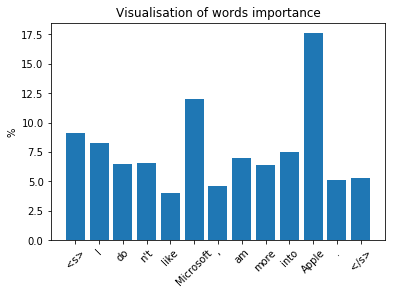

In [50]:
my_sent = "I don't like Microsoft, am more into Apple."
_, _ = model.visualize(my_sent)

# test it on some sentences from an NLP competition

In [49]:
# The two sentences are completely equivalent, as they mean the same thing.  

a="The bird is bathing in the sink."
b="The bird is washing itself in the water basin."
cosine(model.encode([a])[0], model.encode([b])[0])

0.8117823

In [26]:
# The two sentences are mostly equivalent, but some unimportant details differ.
a = "In May 2010, the troops attempted to invade Kabul."
b = "The US army invaded Kabul on May 7th last year, 2010."
cosine(model.encode([a])[0], model.encode([b])[0])

0.83606333

In [27]:
# The two sentences are roughly equivalent, but some important information differs/missing.
a = "John said he is considered a witness but not a suspect."
b = '"He is not a suspect anymore." John said.'
cosine(model.encode([a])[0], model.encode([b])[0])

0.84698379

In [44]:
# The two sentences are not equivalent, but share some details.
a = "They flew out of the nest in groups."
b = "They flew into the nest together."
cosine(model.encode([a])[0], model.encode([b])[0])

0.86487544

In [45]:
# The two sentences are not equivalent, but are on the same topic.

a="The woman is playing the violin."
b="The young lady enjoys listening to the guitar."
cosine(model.encode([a])[0], model.encode([b])[0])

0.68841612

In [46]:
# The two sentences are on different topics.
a = "John went horse back riding at dawn with a whole group of friends."
b = "Sunrise at dawn is a magnificent view to take in if you wake up early enough for it."
cosine(model.encode([a])[0], model.encode([b])[0])

0.6657024